In [136]:
#Computation & Visualisation packages
library(knitr)
library(ggplot2)
library(plyr)
library(dplyr)
library(corrplot)
library(caret)
library(gridExtra)
library(scales)
library(Rmisc)
library(ggrepel)
library(randomForest)
library(psych)
library(xgboost)
library(caTools)

# Suppress warnings
options(warn=-1)

In [137]:
#Loading the housing dataset
data <- read.csv('data/housing_prices.csv', stringsAsFactor=F)

In [138]:
nrow(data)
str(data)

[1] 2919

'data.frame':	2919 obs. of  81 variables:
 $ Id           : int  1 2 3 4 5 6 7 8 9 10 ...
 $ MSSubClass   : int  60 20 60 70 60 50 20 60 50 190 ...
 $ MSZoning     : chr  "RL" "RL" "RL" "RL" ...
 $ LotFrontage  : int  65 80 68 60 84 85 75 NA 51 50 ...
 $ LotArea      : int  8450 9600 11250 9550 14260 14115 10084 10382 6120 7420 ...
 $ Street       : chr  "Pave" "Pave" "Pave" "Pave" ...
 $ Alley        : chr  NA NA NA NA ...
 $ LotShape     : chr  "Reg" "Reg" "IR1" "IR1" ...
 $ LandContour  : chr  "Lvl" "Lvl" "Lvl" "Lvl" ...
 $ Utilities    : chr  "AllPub" "AllPub" "AllPub" "AllPub" ...
 $ LotConfig    : chr  "Inside" "FR2" "Inside" "Corner" ...
 $ LandSlope    : chr  "Gtl" "Gtl" "Gtl" "Gtl" ...
 $ Neighborhood : chr  "CollgCr" "Veenker" "CollgCr" "Crawfor" ...
 $ Condition1   : chr  "Norm" "Feedr" "Norm" "Norm" ...
 $ Condition2   : chr  "Norm" "Norm" "Norm" "Norm" ...
 $ BldgType     : chr  "1Fam" "1Fam" "1Fam" "1Fam" ...
 $ HouseStyle   : chr  "2Story" "1Story" "2Story" "2Story" ...


In [139]:
tail(data)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,⋯,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
2914,2914,160,RM,21,1526,Pave,NA,Reg,Lvl,AllPub,⋯,0,NA,GdPrv,NA,0,6,2006,WD,Normal,NA
2915,2915,160,RM,21,1936,Pave,NA,Reg,Lvl,AllPub,⋯,0,NA,NA,NA,0,6,2006,WD,Normal,NA
2916,2916,160,RM,21,1894,Pave,NA,Reg,Lvl,AllPub,⋯,0,NA,NA,NA,0,4,2006,WD,Abnorml,NA
2917,2917,20,RL,160,20000,Pave,NA,Reg,Lvl,AllPub,⋯,0,NA,NA,NA,0,9,2006,WD,Abnorml,NA
2918,2918,85,RL,62,10441,Pave,NA,Reg,Lvl,AllPub,⋯,0,NA,MnPrv,Shed,700,7,2006,WD,Normal,NA
2919,2919,60,RL,74,9627,Pave,NA,Reg,Lvl,AllPub,⋯,0,NA,NA,NA,0,11,2006,WD,Normal,NA


In [140]:
#Splitting into test and train

train <- data[!is.na(data['SalePrice']),]
test <- data[is.na(data['SalePrice']),]

In [141]:
# Removing ID from test, train and main dataset
testing_identifiers <- test$Id
train$ID <- NULL
test$ID <- NULL
data$ID <- NULL

In [142]:
## Exploring the target variable - SalePrice

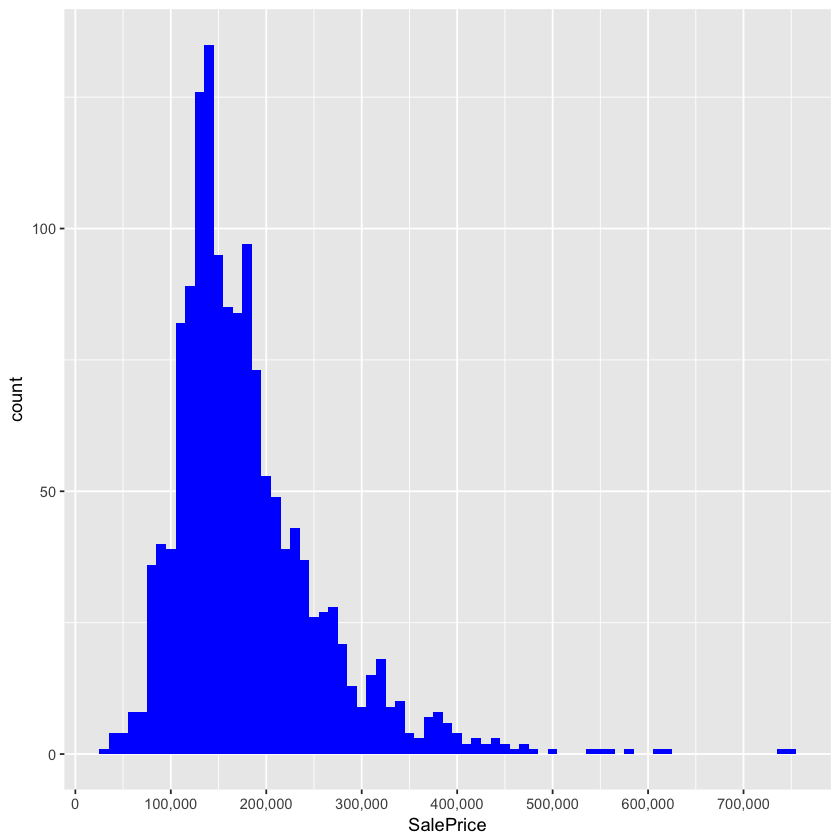

In [143]:
ggplot(data=data[!is.na(data$SalePrice),], aes(x=SalePrice)) + 
    geom_histogram(fill="blue", binwidth = 10000) +
    scale_x_continuous(breaks= seq(0, 800000, by=100000), labels = comma)

In [144]:
## Understanding Correlation with SalePrice variable

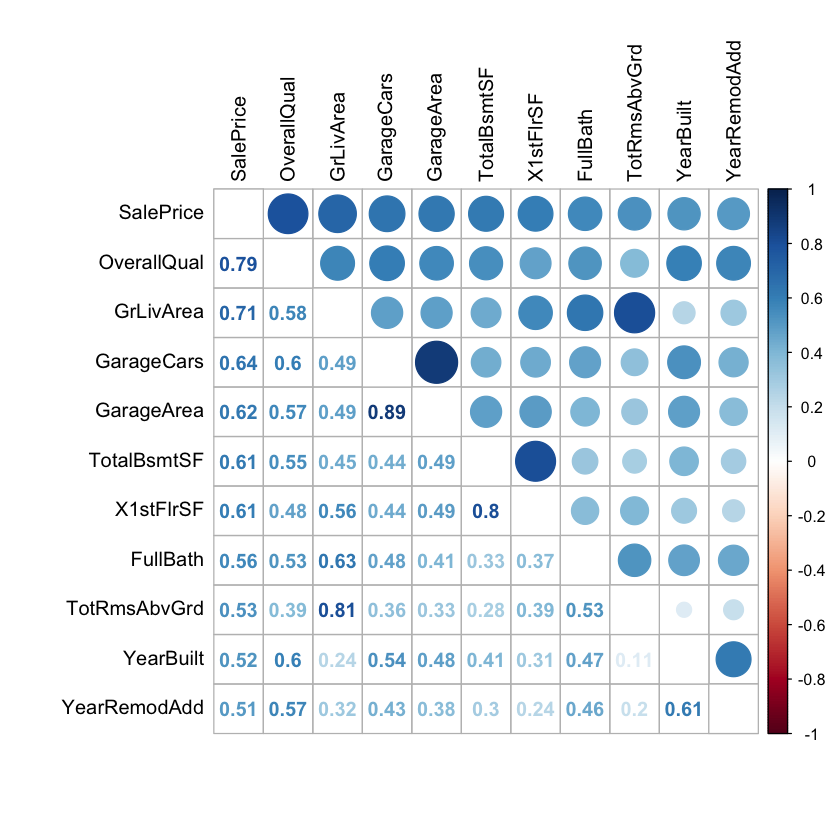

In [145]:
numVariables <- which(sapply(data, is.numeric)) #index vector numeric variables
numVariablesNames <- names(numVariables) #saving names vector for use later on

data_numericVar <- data[, numVariables]
corr_numericVar <- cor(data_numericVar, use="pairwise.complete.obs")
corr_sorted <- as.matrix(sort(corr_numericVar[,'SalePrice'], decreasing = TRUE)) #Descending sort on SalePrice
finalCorr <- names(which(apply(corr_sorted, 1, function(x) abs(x)>0.5))) #Filter highly correlated values
corr_numericVar <- corr_numericVar[CorHigh, CorHigh]

corrplot.mixed(corr_numericVar, tl.col="black", tl.pos = "lt")

In [146]:
## Overall Quality v/s Sales Price

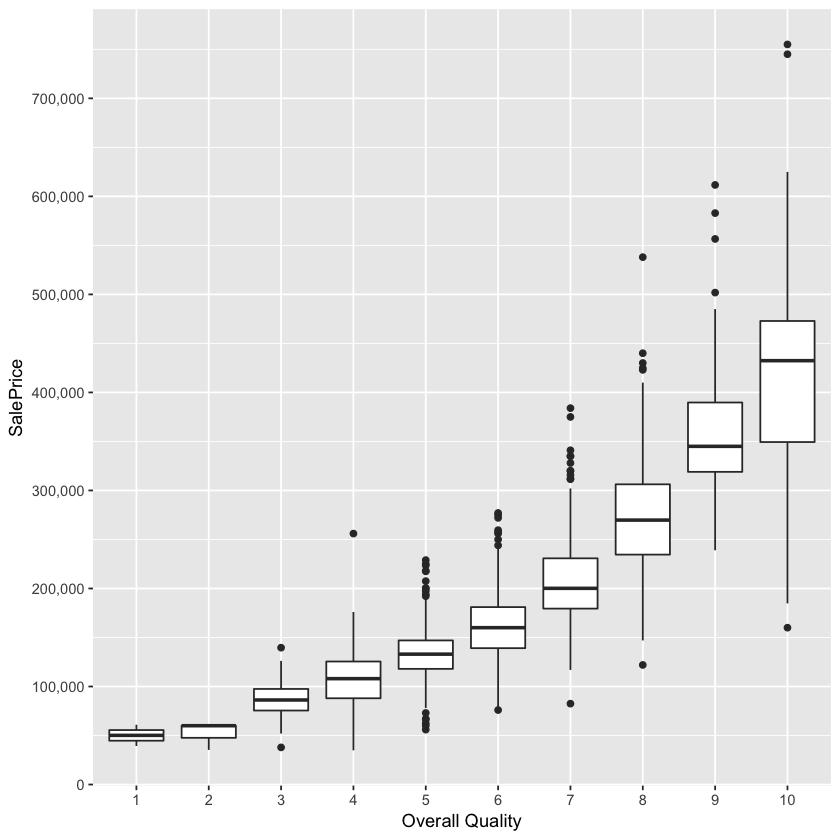

In [147]:
ggplot(data=data[!is.na(data$SalePrice),], aes(x=factor(OverallQual), y=SalePrice))+
        geom_boxplot() + labs(x='Overall Quality') +
        scale_y_continuous(breaks= seq(0, 800000, by=100000), labels = comma)

In [148]:
## Above Ground Living Area v/s Sales Price

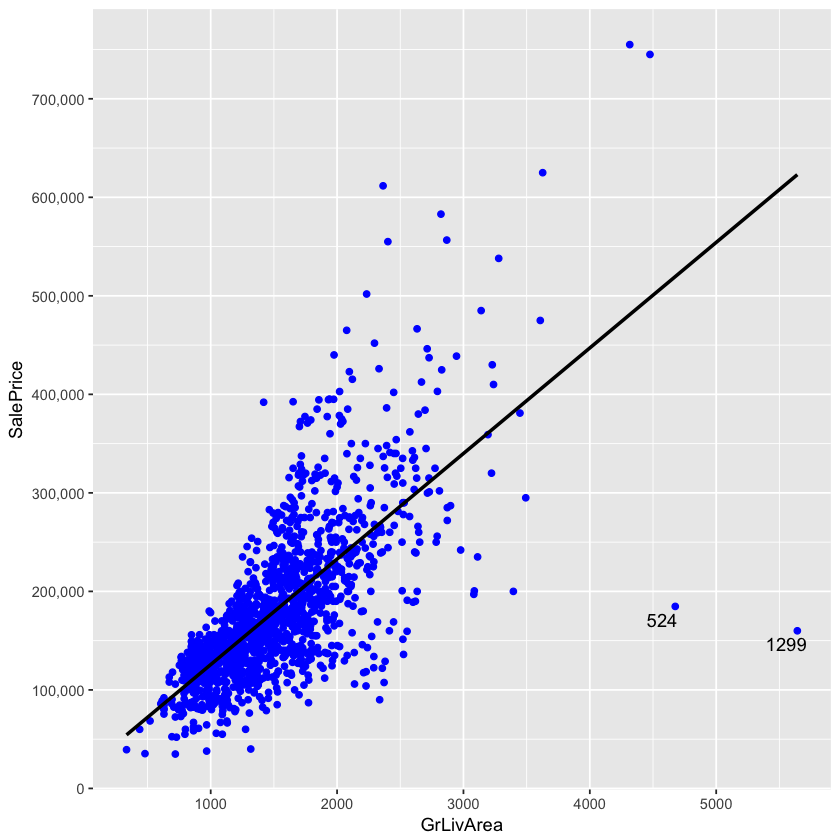

In [149]:
ggplot(data=data[!is.na(data$SalePrice),], aes(x=GrLivArea, y=SalePrice))+
        geom_point(col='blue') + geom_smooth(method = "lm", se=FALSE, color="black", aes(group=1)) +
        scale_y_continuous(breaks= seq(0, 800000, by=100000), labels = comma) +
        geom_text_repel(aes(label = ifelse(data$GrLivArea[!is.na(data$SalePrice)]>4500, rownames(data), '')))


In [150]:
## Imputing missing variables in the dataset

In [151]:
data$PoolQC[is.na(data$PoolQC)] <- 'None'
Qualities <- c('None' = 0, 'Po' = 1, 'Fa' = 2, 'TA' = 3, 'Gd' = 4, 'Ex' = 5)
data$PoolQC <- as.integer(revalue(data$PoolQC, Qualities))

# Miscellaneous Features
data$MiscFeature[is.na(data$MiscFeature)] <- 'None'
data$MiscFeature <- as.factor(data$MiscFeature)

# Garage variables
data$GarageYrBlt[is.na(data$GarageYrBlt)] <- data$YearBuilt[is.na(data$GarageYrBlt)]
data$GarageType[is.na(data$GarageType)] <- 'No Garage'
data$GarageType <- as.factor(data$GarageType)
data$GarageQual[is.na(data$GarageQual)] <- 'None'
data$GarageQual<-as.integer(revalue(data$GarageQual, Qualities))
data$GarageCond[is.na(data$GarageCond)] <- 'None'
data$GarageCond<-as.integer(revalue(data$GarageCond, Qualities))

# Alley Variables
data$Alley[is.na(data$Alley)] <- 'None'
data$Alley <- as.factor(data$Alley)

# Fence Quality
data$Fence[is.na(data$Fence)] <- 'None'

# Fireplace Quality
data$FireplaceQu[is.na(data$FireplaceQu)] <- 'None'
data$FireplaceQu <- as.integer(revalue(data$FireplaceQu, Qualities))

# Lot variables
for (i in 1:nrow(data)){
        if(is.na(data$LotFrontage[i])){
               data$LotFrontage[i] <- as.integer(median(data$LotFrontage[data$Neighborhood==data$Neighborhood[i]], na.rm=TRUE)) 
        }
}

#data$LotShape<-as.integer(revalue(data$LotShape, c('IR3'=0, 'IR2'=1, 'IR1'=2, 'Reg'=3)))
data$LotConfig <- as.factor(data$LotConfig)

# Kitchen, Table, Home Functionality, Exterior Utilities, Electrical Systems, and Scale Type variables
data$KitchenQual[is.na(data$KitchenQual)] <- 'TA' #replace with most common value
data$KitchenQual <- as.integer(revalue(data$KitchenQual, Qualities))
data$Utilities <- NULL
data$Functional[is.na(data$Functional)] <- names(sort(-table(data$Functional)))[1]
data$Functional <- as.integer(revalue(data$Functional, 
              c('Sal'=0, 'Sev'=1, 'Maj2'=2, 'Maj1'=3, 'Mod'=4, 'Min2'=5, 'Min1'=6, 'Typ'=7)))
data$Exterior1st[is.na(data$Exterior1st)] <- names(sort(-table(data$Exterior1st)))[1]
data$Exterior1st <- as.factor(data$Exterior1st)
data$Electrical[is.na(data$Electrical)] <- names(sort(-table(data$Electrical)))[1]

data$Electrical <- as.factor(data$Electrical)
data$SaleType[is.na(data$SaleType)] <- names(sort(-table(data$SaleType)))[1]
data$SaleType <- as.factor(data$SaleType)
data$SaleCondition <- as.factor(data$SaleCondition)

# Masonry & MS Zoning variables 
data$MasVnrType[is.na(data$MasVnrType)] <- 'None'
data$MasVnrArea[is.na(data$MasVnrArea)] <-0
data$MSZoning[is.na(data$MSZoning)] <- names(sort(-table(data$MSZoning)))[1]
data$MSZoning <- as.factor(data$MSZoning)

The following `from` values were not present in `x`: Po, TA
The following `from` values were not present in `x`: None, Po
The following `from` values were not present in `x`: Sal


In [152]:
head(data)

Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,⋯,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1,60,RL,65,8450,Pave,None,Reg,Lvl,Inside,⋯,0,0,None,None,0,2,2008,WD,Normal,208500
2,20,RL,80,9600,Pave,None,Reg,Lvl,FR2,⋯,0,0,None,None,0,5,2007,WD,Normal,181500
3,60,RL,68,11250,Pave,None,IR1,Lvl,Inside,⋯,0,0,None,None,0,9,2008,WD,Normal,223500
4,70,RL,60,9550,Pave,None,IR1,Lvl,Corner,⋯,0,0,None,None,0,2,2006,WD,Abnorml,140000
5,60,RL,84,14260,Pave,None,IR1,Lvl,FR2,⋯,0,0,None,None,0,12,2008,WD,Normal,250000
6,50,RL,85,14115,Pave,None,IR1,Lvl,Inside,⋯,0,0,MnPrv,Shed,700,10,2009,WD,Normal,143000
